In [91]:
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [92]:
# 获取当前日期
current_date = datetime.now().strftime("%Y-%m-%d")

outdir = 'outdir'


# 构建导出的pth文件名以及ONNX文件名
pth_file_path = os.path.join(outdir, f'eeg_fatigue-best_model_{current_date}.pth')
onnx_file_path = os.path.join(outdir, f"eeg_fatigue-best_model_{current_date}.onnx")

Epoch: 0 Train Loss: 0.705705463886261 Test Accuracy: 0.4621833749554049
Best Accuracy Model: 0.4621833749554049
Epoch: 1 Train Loss: 0.6529285907745361 Test Accuracy: 0.4466642882625758
Epoch: 2 Train Loss: 0.6606435179710388 Test Accuracy: 0.442739921512665
Epoch: 3 Train Loss: 0.6522186994552612 Test Accuracy: 0.442739921512665
Epoch: 4 Train Loss: 0.6432535648345947 Test Accuracy: 0.4760970388869069
Best Accuracy Model: 0.4760970388869069
Epoch: 5 Train Loss: 0.6439459323883057 Test Accuracy: 0.43292900463788797
Epoch: 6 Train Loss: 0.6600890755653381 Test Accuracy: 0.47716732072779167
Best Accuracy Model: 0.47716732072779167
Epoch: 7 Train Loss: 0.6605502367019653 Test Accuracy: 0.4407777381377096
Epoch: 8 Train Loss: 0.6340206265449524 Test Accuracy: 0.4662861220121299
Epoch: 9 Train Loss: 0.6470350623130798 Test Accuracy: 0.5032108455226543
Best Accuracy Model: 0.5032108455226543
Epoch: 10 Train Loss: 0.6923458576202393 Test Accuracy: 0.5574384587941491
Best Accuracy Model: 0.55

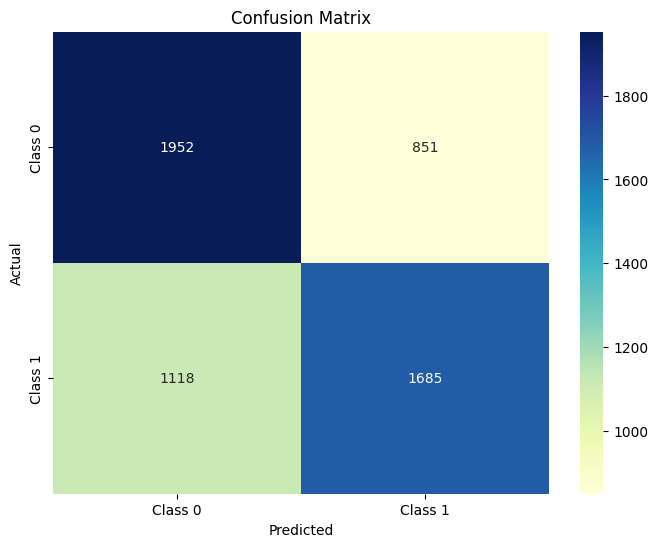

Best Accuracy Model: 0.6833749554049233


In [93]:
class CustomDataset(Dataset):
    def __init__(self, positive_file, negative_file):
        # Load positive samples
        with open(positive_file, 'rb') as f:
            self.positive_samples = pickle.load(f)
        
        # Load negative samples
        with open(negative_file, 'rb') as f:
            self.negative_samples = pickle.load(f)

        # Ensure both sets have the same length
        self.length = min(len(self.positive_samples), len(self.negative_samples))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Concatenate positive and negative samples to form a batch
        positive_feature, positive_label = self.positive_samples[idx % len(self.positive_samples)]
        negative_feature, negative_label = self.negative_samples[idx % len(self.negative_samples)]
        return torch.tensor(positive_feature), torch.tensor(negative_feature)

class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(128, 64)  # Input size 100, output size 64
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout with a probability of 0.5
        self.fc2 = nn.Linear(64, 32)   # Input size 64, output size 32
        self.dropout2 = nn.Dropout(p=0.3)  # Dropout with a probability of 0.5
        self.fc3 = nn.Linear(32, 1)    # Input size 32, output size 1

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Define paths to your data files
train_positive_file = './samples/train_positive_samples.pkl'
train_negative_file = './samples/train_negative_samples.pkl'
test_positive_file = './samples/test_positive_samples.pkl'
test_negative_file = './samples/test_negative_samples.pkl'

# Create datasets
train_dataset = CustomDataset(train_positive_file, train_negative_file)
test_dataset = CustomDataset(test_positive_file, test_negative_file)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model, loss function, and optimizer
model = SimpleDNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer

best_accuracy = 0.0

# Training loop
for epoch in range(100):  # Train for 10 epochs
    for batch_idx, (positive_batch, negative_batch) in enumerate(train_loader):
        # Concatenate positive and negative batches
        inputs = torch.cat((positive_batch, negative_batch), dim=0)
        labels = torch.cat((torch.ones(positive_batch.size(0), 1), torch.zeros(negative_batch.size(0), 1)), dim=0)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs.float())  # Forward pass
        loss = criterion(outputs, labels.float())  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # Testing loop
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    total_samples = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for positive_batch, negative_batch in test_loader:
            inputs = torch.cat((positive_batch, negative_batch), dim=0)
            labels = torch.cat((torch.ones(positive_batch.size(0), 1), torch.zeros(negative_batch.size(0), 1)), dim=0)
            
            outputs = model(inputs.float())
            predicted = (outputs > 0.5).float()  # Threshold at 0.5
            total_samples += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    accuracy = test_correct / total_samples
    print(f'Epoch: {epoch} Train Loss: {loss} Test Accuracy: {accuracy}')

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), pth_file_path)
        print("Best Accuracy Model: {}".format(best_accuracy))

        # Export the best model to ONNX
        dummy_input = torch.randn(1, 128)
        torch.onnx.export(model, dummy_input, onnx_file_path, input_names=['input'], output_names=['output'])
    


# Load the best model
model.load_state_dict(torch.load(pth_file_path))

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)



# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
labels = ['Class 0', 'Class 1'] 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print("Best Accuracy Model: {}".format(best_accuracy))
